In [1]:
## http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#python -m spacy download en
import spacy
import en_core_web_sm ## because spacy is being annoying

import pyLDAvis

## we want this for plotting, but it's overwriting gensim
#from pyLDAvis import gensim

import logging
logging.basicConfig(format= '%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
import nltk

## required?
import sputnik

import os

import time

import matplotlib.pyplot as plt

C:\Users\Felicity Splatt\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
## https://www.kaggle.com/cfpb/us-consumer-finance-complaints/version/1
df = pd.read_csv('C://Users/Felicity Splatt/Documents/00_Personal/consumer_complaints.csv')

df = df.dropna(axis='index', subset=['consumer_complaint_narrative'])
df.head()

C:\Users\Felicity Splatt\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


In [4]:
## remove newline characters
df.consumer_complaint_narrative = df.consumer_complaint_narrative.replace(r'\s', ' ', regex=True)
df.consumer_complaint_narrative = df.consumer_complaint_narrative.replace(r'\\n', ' ', regex=True)

## convert verbatim column to list
data = df.consumer_complaint_narrative.values.tolist()

In [5]:
def para_to_words(paragraph):
    for para in paragraph:
        yield(gensim.utils.simple_preprocess(str(para), deacc=True))

data_words = list(para_to_words(data))

print(data_words[:1])

[['xxxx', 'has', 'claimed', 'owe', 'them', 'for', 'xxxx', 'years', 'despite', 'the', 'proof', 'of', 'payment', 'sent', 'them', 'canceled', 'check', 'and', 'their', 'ownpaid', 'invoice', 'for', 'they', 'continue', 'to', 'insist', 'owe', 'them', 'and', 'collection', 'agencies', 'are', 'after', 'me', 'how', 'can', 'stop', 'this', 'harassment', 'for', 'bill', 'already', 'paid', 'four', 'years', 'ago']]


In [6]:
## build bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Felicity Splatt\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['xxxx', 'has', 'claimed', 'owe', 'them', 'for', 'xxxx', 'years', 'despite', 'the', 'proof', 'of', 'payment', 'sent', 'them', 'canceled', 'check', 'and', 'their', 'ownpaid', 'invoice', 'for', 'they', 'continue', 'to', 'insist', 'owe', 'them', 'and', 'collection', 'agencies', 'are', 'after', 'me', 'how', 'can', 'stop', 'this', 'harassment', 'for', 'bill', 'already', 'paid', 'four', 'years', 'ago']


In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\Felicity
[nltk_data]     Splatt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
## manually add stopwords
stop_words.update(('xxxx'))

In [51]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

## lemmatization - stemming, etc
## keep only nouns, adjectives, verbs and adverbs
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [52]:
## remove stopwords
data_words_nostops = remove_stopwords(data_words)

## create bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

## these two do not work
#nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## initialise space 'en_core_web_sm' model
## model has vocabularly, syntax, entities
## this is the version that I did get to work
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:1])

In [ ]:
## check that xxxx has been removed

In [11]:
## create dictionary - maps all words to a word id?
id2word = corpora.Dictionary(data_lemmatized)

## create corpus - a mapping of [word_id, word_frequency]
texts = data_lemmatized

## term document frequency
corpus = [id2word.doc2bow(text) for text in texts]
#print(corpus[:1])

In [12]:
## human-readable dictiorinary, if you want to have a look
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [13]:
## LDA model
lda_model = gensim.models.ldamodel.LdaModel(

    corpus = corpus
    ,id2word = id2word ## dictionary
    
    ## later we'll loop through this
    ,num_topics = 6
    ,random_state = 100
    ,update_every = 1
    ,chunksize = 100
    
    ## how to know what to set this to?
    ,passes = 10
    
    ,alpha = 'auto'
    ,per_word_topics = True
)

In [14]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"payment" + 0.061*"pay" + 0.039*"make" + 0.033*"month" + '
  '0.028*"charge" + 0.027*"amount" + 0.025*"fee" + 0.025*"balance" + '
  '0.023*"late" + 0.022*"due"'),
 (1,
  '0.803*"xxxx" + 0.011*"date" + 0.004*"name" + 0.004*"show" + 0.004*"number" '
  '+ 0.004*"status" + 0.003*"see" + 0.003*"state" + 0.003*"also" + '
  '0.003*"record"'),
 (2,
  '0.081*"loan" + 0.051*"mortgage" + 0.027*"home" + 0.017*"modification" + '
  '0.012*"property" + 0.012*"wells_fargo" + 0.012*"year" + 0.011*"tax" + '
  '0.011*"foreclosure" + 0.010*"house"'),
 (3,
  '0.032*"file" + 0.024*"law" + 0.019*"fraud" + 0.018*"fraudulent" + '
  '0.017*"act" + 0.017*"consumer" + 0.015*"complaint" + 0.015*"fair" + '
  '0.014*"bankruptcy" + 0.013*"right"'),
 (4,
  '0.049*"call" + 0.032*"tell" + 0.029*"get" + 0.026*"would" + 0.026*"say" + '
  '0.021*"time" + 0.019*"go" + 0.016*"ask" + 0.015*"phone" + 0.015*"back"'),
 (5,
  '0.115*"account" + 0.099*"bank" + 0.076*"card" + 0.055*"check" + '
  '0.022*"america" + 0.0

In [15]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.474277633087947

Coherence Score:  0.4624044618760994


In [ ]:
## this is not working - it does not like pyLDAvis.gensim
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

In [ ]:
## TODO: cannot get this to work

#from gensim.models.wrappers import LdaMallet
#os.environ['MALLET_HOME'] = 'C:\\Users\\Felicity Splatt\\mallet-2.0.8'
#mallet_path = 'C:\\Users\\Felicity Splatt\\mallet-2.0.8'
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
#pprint(ldamallet.show_topics(.)formatted=False))
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

In [16]:
## a function to try different "num_topics", so we can choose a value that makes sense

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        ## not working - cannot get it to find mallet for some reason
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        ## so let's use instead LDA
        model = gensim.models.ldamodel.LdaModel(
            corpus = corpus
            ,id2word = id2word
            
            ## variable, we will loop over
            ,num_topics = num_topics
            ,random_state = 100
            ,update_every = 1
            ,chunksize = 100
            ,passes = 10
            ,alpha = 'auto'
            ,per_word_topics = True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
## use our function above

## 100 minutes to run 2 models

start_time = time.clock()

model_list, coherence_values = compute_coherence_values(
    dictionary = id2word
    ,corpus = corpus
    ,texts = data_lemmatized
    ,start = 4
    ,limit = 15
    ,step = 1
    )


print("--- %s minutes ---" % (time.clock() - start_time)/60)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [42]:
model_list[4]

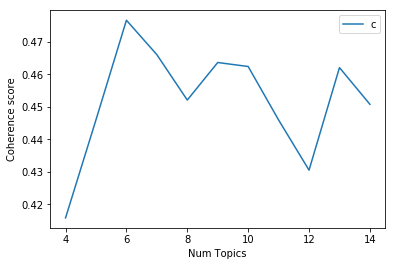

In [48]:
## determine best coherence value - essentially like k-means where we're looking for an "elbow" in the curve
limit = 15; start = 4; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.4159
Num Topics = 5  has Coherence Value of 0.446
Num Topics = 6  has Coherence Value of 0.4766
Num Topics = 7  has Coherence Value of 0.466
Num Topics = 8  has Coherence Value of 0.4521
Num Topics = 9  has Coherence Value of 0.4636
Num Topics = 10  has Coherence Value of 0.4624
Num Topics = 11  has Coherence Value of 0.446
Num Topics = 12  has Coherence Value of 0.4306
Num Topics = 13  has Coherence Value of 0.4621
Num Topics = 14  has Coherence Value of 0.4508


In [38]:
## manually select the "best" model
optimal_model = model_list[1]

## print the topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"account" + 0.033*"bank" + 0.032*"payment" + 0.029*"card" + '
  '0.027*"charge" + 0.023*"fee" + 0.022*"credit" + 0.018*"pay" + 0.018*"check" '
  '+ 0.016*"make"'),
 (1,
  '0.406*"xxxx" + 0.013*"receive" + 0.011*"letter" + 0.010*"request" + '
  '0.010*"state" + 0.009*"date" + 0.007*"complaint" + 0.007*"provide" + '
  '0.007*"send" + 0.006*"file"'),
 (2,
  '0.055*"loan" + 0.037*"payment" + 0.034*"mortgage" + 0.017*"home" + '
  '0.014*"pay" + 0.013*"make" + 0.013*"month" + 0.012*"modification" + '
  '0.011*"year" + 0.009*"time"'),
 (3,
  '0.086*"credit" + 0.073*"report" + 0.043*"debt" + 0.039*"account" + '
  '0.024*"collection" + 0.024*"dispute" + 0.022*"information" + 0.019*"agency" '
  '+ 0.018*"remove" + 0.012*"experian"'),
 (4,
  '0.043*"call" + 0.027*"tell" + 0.023*"get" + 0.022*"say" + 0.021*"would" + '
  '0.016*"time" + 0.016*"ask" + 0.014*"go" + 0.013*"pay" + 0.013*"phone"')]


In [ ]:
del lda

In [39]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [ ]:
## find the most representative document for each topic

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
    
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

sent_topics_sorteddf_mallet.head()

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics